<font color = 'blue'>
    
# WeRateDogs


## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gathering">Gathering Data</a></li>
<li><a href="#ad">Assessing Data</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#insight">Insights & Visualizations</a></li>
</ul>
</font>

<a id='intro'></a>
<font color='blue'>
    
## Introduction
<br>
WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. The account was started in 2015 by college student Matt Nelson, and has received international media attention both for its popularity and for the attention drawn to social media copyright law when it was suspended by Twitter for breaking these aforementioned laws. WeRateDogs has over 7 million followers.

For this project I will be working with the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. 

The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets. The archive contains each tweet's text, which was then used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced". 

Additionaly, retweet count and favorite count are two column data can be downloaded using Twitter's API.

And finally a full list of image predictions of the top three dog breeds.

Referrences : [WeRateDogs - Wikipedia](https://en.wikipedia.org/wiki/WeRateDogs?)
</font>

In [106]:
import pandas as pd
import numpy as np
import requests as rq
import seaborn as sns
from tweepy import OAuthHandler
from timeit import default_timer as timer
import tweepy
import json
from pandas.io.json import json_normalize
pd.set_option("display.max_colwidth", 180)
pd.set_option("display.max_columns", 40)
%matplotlib inline
import datetime

<a id='gathering'></a>
<font color='Blue'>

### Gathering data
#### The following files are gathered and loaded
1. twitter-archive-enhanced.csv
2. image-predictions.tsv
3. tweet_json.txt
</font>

<font color ='blue'>
    
##### Loading twitter-archive-enhanced.csv
</font>

In [3]:
tw_ar_df = pd.read_csv('twitter-archive-enhanced.csv')
tw_ar_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None


<font color='blue'>

##### Loading image-predictions.tsv
</font>

In [4]:
r = rq.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv', allow_redirects=True)
open('image-predictions.tsv','wb').write(r.content)

335079

In [5]:
im_df = pd.read_csv('image-predictions.tsv', sep='\t')
im_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<font color = 'blue'>

##### Loading tweet_json.txt
</font>

In [38]:
CONSUMER_KEY = ""
CONSUMER_SECRET = ""
OAUTH_TOKEN = ""
OAUTH_TOKEN_SECRET = ""

auth = OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)
tweet_ids = tw_ar_df.tweet_id.values
len(tweet_ids)
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293: 838083903487373313
Success


Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success
550: 805207613751304193
Success
551: 804738756058218496
Success


Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807: 772102971039580160
Success
808: 771908950375665664
Success
809

Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
1062: 741303864243200000
Success
1063: 741099773336379392
Success
10

Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
1311: 707038192327901184
Success
1312: 707021089608753152
Success
13

Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
1560: 688547210804498433
Success
1561: 688519176466644993
Success
1562: 688385280030670848
Success
15

Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
1810: 676864501615042560
Success
1811: 676821958043033607
Success
1812: 676819651066732545
Success
18

Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
2059: 671347597085433856
Success
2060: 671186162933985280
Success
2061: 671182547775299584
Success
20

Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
2308: 666826780179869698
Success
2309: 666817836334096384
Success
2310: 666804364988780544
Success
23

In [6]:
jtweets = [json.loads(line) for line in open('tweet_json.txt', 'r')]
twjs_df = pd.DataFrame(jtweets)
twjs_df.head(2)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http:/...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'h...",37024,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,892420643555336193,892420643555336193,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,NaN,7899,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': '「 DM YOUR DOGS 」', 'description': 'Your Only Source For Professional ..."
1,None,None,Tue Aug 01 00:17:27 +0000 2017,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http:...","{'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': '...",31860,False,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",None,892177421306343426,892177421306343426,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,NaN,5870,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': '「 DM YOUR DOGS 」', 'description': 'Your Only Source For Professional ..."


<a id='ad'></a>
<font color='blue'>
    
### Assessing data

#### 1. Assessing twitter-archive-enhanced.csv

In [7]:
tw_ar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

<font color='blue'>

While scrutinizing the twitter-archive-enhanced.csv I noticed that people have uploaded pictures of other animals and not dogs.
</font>

In [8]:
tw_ar_df.loc[tw_ar_df.text.str.contains('We only rate dogs')][['text','name']]

,text,name
25,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,None
59,Ugh not again. We only rate dogs. Please don't send in well-dressed floppy-tongued street penguins. Dogs only please. Thank you... 12/10 https://t.co/WiAMbTkDPf,None
93,"I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10 https://t.co/pwY9PQhtP2",None
118,RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,quite
127,"Unbelievable. We only rate dogs. Please don't send in non-canines like the ""I"" from Pixar's opening credits. Thank you... 12/10 https://t.co/JMhDNv5wXZ",None
131,"Oh my this spooked me up. We only rate dogs, not happy ghosts. Please send dogs only. It's a very simple premise. Thank you... 13/10 https://t.co/M5Rz0R8SIQ",None
141,We only rate dogs. Please don't send in Jesus. We're trying to remain professional and legitimate. Thank you... 14/10 https://t.co/wr3xsjeCIR,None
154,We only rate dogs. Please don't send perfectly toasted marshmallows attempting to drive. Thank you... 13/10 https://t.co/nvZyyrp0kd,None
169,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,quite
221,Seriously guys? Again? We only rate dogs. Please stop submitting other things like this super good hammerhead shark. Thank you... 12/10 https://t.co/TCMC90mSOT,None


In [9]:
tw_ar_df.loc[tw_ar_df.text.str.contains('we only rate dogs')][['text','name']]

,text,name
193,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",quite
506,"RT @dog_rates: Meet Sammy. At first I was like ""that's a snowflake. we only rate dogs,"" but he would've melted by now, so 10/10 https://t.c…",Sammy
869,Guys.. we only rate dogs. Pls don't send any more pics of the Loch Ness Monster. Only send in dogs. Thank you. 11/10 https://t.co/obH5vMbm1j,None
1085,"For the last time, we only rate dogs. Pls stop sending other animals like this Duck-Billed Platypus. Thank you. 9/10 https://t.co/twxYcPOafl",None
1225,"I know we only rate dogs, but since it's Easter I guess we could rate a bunny for a change. 10/10 petable as hell https://t.co/O2RlKXigHu",None
1356,"Really guys? Again? I know this is a rare Albanian Bingo Seal, but we only rate dogs. Only send in dogs... 9/10 https://t.co/6JYLpUmBrC",None
1726,"Meet Sammy. At first I was like ""that's a snowflake. we only rate dogs,"" but he would've melted by now, so 10/10 https://t.co/MQfPK4zwuh",Sammy


<font color = 'blue'>

While performing a visual analysis of the data in Google sheets I noticed many invalid names in the <B>name</B> column. Given below is an exploratory analysis of few of such invalid names.

</font>

In [10]:
invalid_names = tw_ar_df[tw_ar_df.name.isin(['None','a','an','very','the','not','one','just','actually'])]['name'].value_counts()
invalid_names

None        745
a            55
the           8
an            7
very          5
just          4
one           4
not           2
actually      2
Name: name, dtype: int64

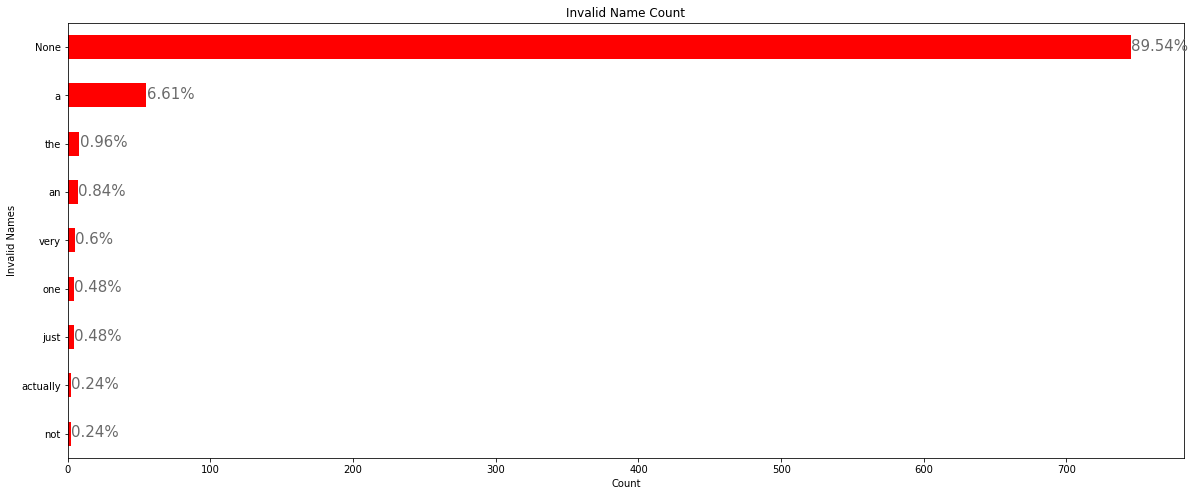

In [11]:
inn = invalid_names.sort_values(ascending=True).plot.barh(figsize=(20,8), color='r');
inn.set_title('Invalid Name Count');
inn.set_xlabel('Count');
inn.set_ylabel('Invalid Names');

totals = []

for i in inn.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in inn.patches:
    # get_width pulls left or right; get_y pushes up or down
    inn.text(i.get_width()+.3, i.get_y()+.18, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

<font color='blue'>

I've found the following records where the <B>name</B> column contained <I>'None'</I>. However, the <B>text</B> column contains a valid dog name .
</font>

In [12]:
tw_ar_df.loc[tw_ar_df.name == 'None'][['text','name']].head()

,text,name
5,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,None
7,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,None
12,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,None
24,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,None
25,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,None


In [13]:
tw_ar_df.loc[tw_ar_df.name == 'a'][['text','name']].head()

,text,name
56,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
649,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
801,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
1002,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
1004,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a


<font color='blue'>
    
Based on the above two queries (i.e. where name was either 'None' or 'a') the following records contain valid dog names. 
</font>

In [14]:
tw_ar_df.loc[tw_ar_df.index.isin([72,101,369,649,2352,775])][['text','name']]

,text,name
72,Martha is stunning how h*ckin dare you. 13/10 https://t.co/9uABQXgjwa,None
101,"RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. htt…",None
369,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
649,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
775,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O
2352,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,a


In [15]:
tw_ar_df.loc[tw_ar_df.name == 'Eazy'][['text','name']]

,text,name
1392,This is Eazy-E. He's colorful af. Must be rare. Submerged in Sprite (rad). Doesn't perform well when not wet. 6/10 https://t.co/UtFI7eUCjE,Eazy


<font color='blue'>

In the query below, when exploring the <B>text</B> column, I am able to find more valid dog names after strings such as 'named..' or 'name is ..'.
</font>

In [16]:
tw_ar_df.loc[tw_ar_df.text.str.contains('named')][['text','name']]

,text,name
603,RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,None
1853,This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,a
1955,This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,a
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,a
2066,This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,a
2116,This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,a
2125,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,a
2128,This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,a
2146,This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,a
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,a


In [17]:
tw_ar_df.loc[tw_ar_df.text.str.contains('name is')][['text','name']]

,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,None
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,None
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,None
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,None
2267,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,None
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,a
2313,This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,Lugan


<font color='blue'>
    
Investgating the rating denominator.
</font>

In [18]:
tw_ar_df.loc[tw_ar_df.rating_denominator > 10][['text','rating_denominator']]

,text,rating_denominator
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80


In [19]:
tw_ar_df.loc[tw_ar_df.rating_denominator < 10][['text','rating_denominator']]

,text,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,2


<font color='blue'>

Below is an exploratory analysis of the invalid rating entries
</font>

In [20]:
denocount = {}
def denoRateCount(df,c=10,gr10="Greater than 10", ls10="Less than 10"):
    denocount[gr10] = df.loc[df.rating_denominator > c]['rating_denominator'].count()
    denocount[ls10] = df.loc[df.rating_denominator < c]['rating_denominator'].count()
    return denocount

In [21]:
denoRateCount(tw_ar_df)

{'Greater than 10': 20, 'Less than 10': 3}

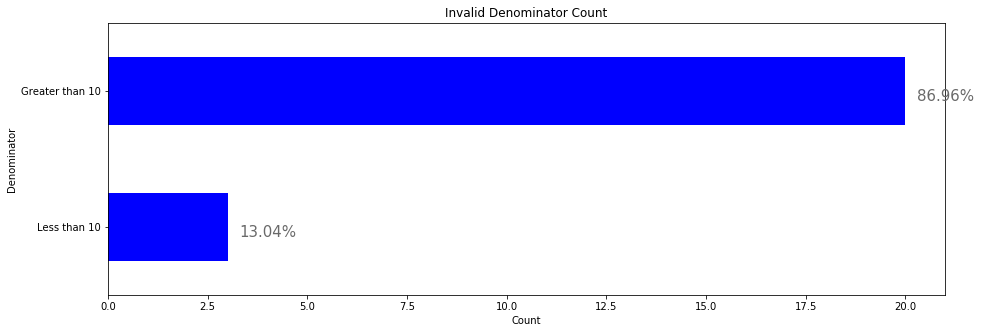

In [22]:
denorate = pd.Series(denocount)
grh = denorate.sort_values(ascending=True).plot.barh(figsize=(15,5), color='blue');
grh.set_title('Invalid Denominator Count');
grh.set_xlabel('Count');
grh.set_ylabel('Denominator');

totals = []

for i in grh.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in grh.patches:
    # get_width pulls left or right; get_y pushes up or down
    grh.text(i.get_width()+.3, i.get_y()+.18, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

<font color='blue'>
  
Based on the above two queries the following records seem to have the wrong rating_denominator captured.
</font>

In [23]:
tw_ar_df.loc[tw_ar_df.index.isin([784,1068,1165,1202,1662,313,2335])][['text','rating_denominator']]

,text,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",11
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,11
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,2


<font color='blue'>

Investigating the dog "stage" (i.e. doggo, floofer, pupper, and puppo)

Below is an exploratory analysis of the dog stage count.
</font>

In [24]:
dogstagecount = {}
def dogStageCount(df,s1="doggo",s2="floofer",s3="pupper",s4="puppo"):
    dogstagecount[s1] = df.loc[df[s1] == s1][s1].value_counts()[0]
    dogstagecount[s2] = df.loc[df[s2] == s2][s2].value_counts()[0]
    dogstagecount[s3] = df.loc[df[s3] == s3][s3].value_counts()[0]
    dogstagecount[s4] = df.loc[df[s4] == s4][s4].value_counts()[0]
    dogstagecount["None"] = tw_ar_df.loc[(tw_ar_df[s1] == 'None') & (tw_ar_df[s2] == 'None') & (tw_ar_df[s3] == 'None') & (tw_ar_df[s4] == 'None')]['tweet_id'].count()
    return dogstagecount

In [25]:
dogStageCount(tw_ar_df)
dogstagecount.items()

dict_items([('doggo', 97), ('floofer', 10), ('pupper', 257), ('puppo', 30), ('None', 1976)])

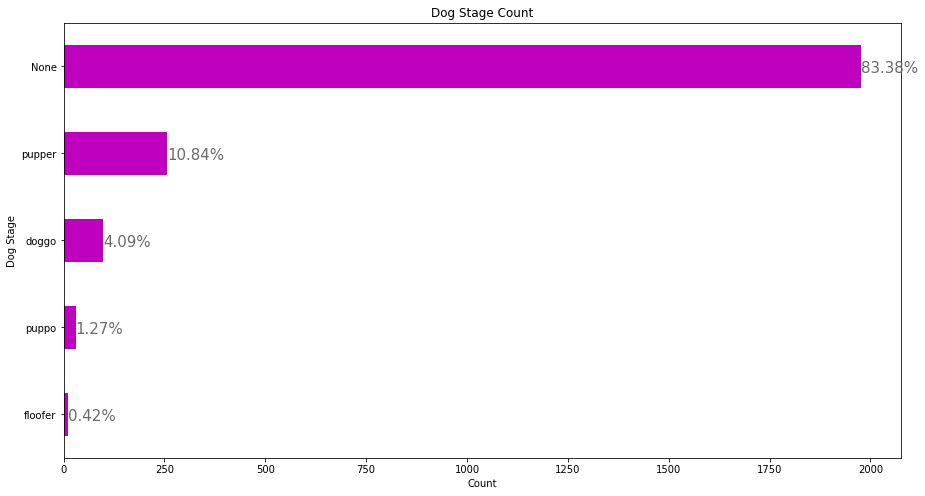

In [26]:
dogstage = pd.Series(dogstagecount)
ds = dogstage.sort_values(ascending=True).plot.barh(figsize=(15,8), color='m');
ds.set_title('Dog Stage Count');
ds.set_xlabel('Count');
ds.set_ylabel('Dog Stage');

totals = []

for i in ds.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ds.patches:
    # get_width pulls left or right; get_y pushes up or down
    ds.text(i.get_width()+.3, i.get_y()+.18, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

In [27]:
tw_ar_df[tw_ar_df.text.str.extract('([a-zA-Z]?[D/d]oggo[a-zA-Z])')[0].notnull()][['text','doggo']]

,text,doggo
83,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,None
268,Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL,None
302,"RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…",None
475,RT @dog_rates: Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://…,None
477,Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://t.co/r4W111FzAq https://t.co/fQpYuMKG3p,None
798,You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV,None
934,Here we are witnessing an isolated squad of bouncing doggos. Unbelievably rare for this time of year. 11/10 for all https://t.co/CCdlwiTwQf,None
946,Here are three doggos completely misjudging an airborne stick. Decent efforts tho. All 9/10 https://t.co/HCXQL4fGVZ,None
987,This is Dietrich. He hops at random. Other doggos don't understand him. It upsets him greatly. 8/10 would comfort https://t.co/U8cSRz8wzC,None
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,None


In [28]:
tw_ar_df[tw_ar_df.text.str.extract('([a-zA-Z]?[F/f]loofer[a-zA-Z])')[0].notnull()][['text','floofer']]

,text,floofer


In [29]:
tw_ar_df[tw_ar_df.text.str.extract('([a-zA-Z]?[P/p]upper[a-zA-Z])')[0].notnull()][['text','pupper']]

,text,pupper
54,This is Gary. He couldn't miss this puppertunity for a selfie. Flawless focusing skills. 13/10 would boop intensely https://t.co/7CSWCl8I6s,None
536,This is Lennon. He's a Boopershnoop Pupperdoop. Quite rare. Exceptionally pettable. 12/10 would definitely boop that shnoop https://t.co/fhgP6vSfhX,None
993,This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd,None
1027,This is Arlen and Thumpelina. They are best pals. Cuddly af. 11/10 for both puppers https://t.co/VJgbgIzIHx,None
1093,Everybody stop what you're doing and watch these puppers enjoy summer. Both 13/10 https://t.co/wvjqSCN6iC,None
1220,Here are two lil cuddly puppers. Both 12/10 would snug like so much https://t.co/zO4eb7C4tG,None
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,None
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,None
1265,"WeRateDogs stickers are here and they're 12/10! Use code ""puppers"" at checkout 🐶🐾\n\nShop now: https://t.co/k5xsufRKYm https://t.co/ShXk46V13r",None
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,None


In [30]:
tw_ar_df[tw_ar_df.text.str.extract('([P/p]uppo[a-zA-Z])')[0].notnull()][['text','puppo']]

,text,puppo
85,"Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https://t.co/ejExJFq3ek",None
106,Say hello to Lassie. She's celebrating #PrideMonth by being a splendid mix of astute and adorable. Proudly supupporting her owner. 13/10 https://t.co/uK6PNyeh9w,None
134,This is Lili. She can't believe you betrayed her with bath time. Never looking you in the eye again. 12/10 would puppologize profusely https://t.co/9b9J46E86Z,None
172,I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq,None
228,Jerry just apuppologized to me. He said there was no ill-intent to the slippage. I overreacted I admit. Pupgraded to an 11/10 would pet,None
274,@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin,None
296,This is Lucy. She has a portrait of herself on her ear. Excellent for identification pupposes. 13/10 innovative af https://t.co/uNmxbL2lns,None
545,This is Duke. He is not a fan of the pupporazzi. 12/10 https://t.co/SgpBVYIL18,None


<font color='blue'>
    
#### 2. Assessing Tweet_json.txt
</font>

In [31]:
twjs_df.head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,place,possibly_sensitive,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http:/...","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'h...",37024,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,892420643555336193,892420643555336193,None,NaN,None,NaN,None,False,en,None,False,False,NaN,NaN,NaN,NaN,7899,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs®', 'screen_name': 'dog_rates', 'location': '「 DM YOUR DOGS 」', 'description': 'Your Only Source For Professional ..."


In [32]:
twjs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       104 non-null object
display_text_range               104 non-null object
entities                         104 non-null object
extended_entities                90 non-null object
favorite_count                   104 non-null int64
favorited                        104 non-null bool
full_text                        104 non-null object
geo                              0 non-null object
id                               104 non-null int64
id_str                           104 non-null object
in_reply_to_screen_name          3 non-null object
in_reply_to_status_id            3 non-null float64
in_reply_to_status_id_str        3 non-null object
in_reply_to_user_id              3 non-null float64
in_reply_to_user_id_str          3 non-null object
is_quote_stat

<font color='blue'>

#### 3. Assessing image-predictions.tsv

In [33]:
im_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [34]:
im_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


<font color='blue'>
    
#### Quality

<font color='blue'> 
    twitter-archive-enhanced.csv
<ol>
  <li><a href="#1">Entries not related to dogs</a></li>
  <li><a href="#2">Entries with valid dogs names after strings such as 'named..' or 'name is ..'. but not captured in the <B>name</B> column</a></li>
  <li><a href="#3">Entries with <B>name</B> column with either 'None' or 'a' but has valid dog names in the text</a></li>
  <li><a href="#4">Entries where the <B>rating_denominator</B> is greater than 10 but has valid denominators in the text</a></li>
  <li><a href="#5">Entries where the <B>rating_denominator</B> is less than 10 but has valid denominators in the text</a></li>
  <li><a href="#6">Entries with invalid <B>rating_denominator</B></a></li>
  <li><a href="#7">Entries that contain doggo in the text but not captured in the <B>doggo</B> column</a></li>
  <li><a href="#8">Entries that contain pupper in the text but not captured in the <B>pupper</B> column</a></li>
  <li><a href="#9">Entries that contain puppo in the text but not captured in the <B>puppo</B> column</a></li>
<br>
    
#### Tidiness
<br>
  <li><a href="#10">Merge retweet and favorite_count columns from tweet_json dataset with twitter-archive-enhanced dataset</a></li>
  <li><a href="#11">Merge image-predictions dataset with twitter-archive-enhanced dataset</a></li>
</ol>
</font>

</font>

<a id='clean'></a>
<font color='blue'>

### Cleaning of data

</font>

<font color='blue'>
    <a id='1'></a>
    
#### Entries not related to dogs

##### Define
Given the fact that Twitter account is meant to be about dogs, I've decided that as a first step I'll be dropping all records that are not related dogs.

</font>

<font color='blue'>

##### Code

In [35]:
tw_ar_mast_df = tw_ar_df.copy()

In [36]:
tw_ar_mast_df = tw_ar_mast_df.drop(tw_ar_mast_df.loc[tw_ar_mast_df.text.str.contains('we only rate dogs')].index)

In [37]:
tw_ar_mast_df = tw_ar_mast_df.drop(tw_ar_mast_df.loc[tw_ar_mast_df.text.str.contains('We only rate dogs')].index)

<font color='blue'>

##### Test
</font>

<font color='blue'>
After successfully running the above query the count should be zero.
</font>

In [38]:
tw_ar_mast_df.loc[tw_ar_mast_df.text.str.contains('we only rate dogs')]['name'].count()

0

In [39]:
tw_ar_mast_df.loc[tw_ar_mast_df.text.str.contains('We only rate dogs')]['name'].count()

0

<font color='blue'>
    
<a id='2'></a>
#### Entries with valid dogs names after strings such as 'named..' or 'name is ..'. but not captured in the <B>name</B> column</a>

##### Define
When investigating the <B>text</B> column I noticed that there were entries where valid dog names were given after strings such as 'named...' or 'name is...'. However, they were not captured in the <B>name</B> column. The below code will extract the names and populate them in the <B>name</B> column.
</font>

<font color='blue'>

##### Code
</font>

In [40]:
namelst = tw_ar_mast_df.loc[tw_ar_mast_df.text.str.contains('named')]['name']
namelst.index

Int64Index([ 603, 1853, 1955, 2034, 2066, 2116, 2125, 2128, 2146, 2161, 2166,
            2191, 2204, 2218, 2227, 2235, 2249, 2255, 2264, 2269, 2273, 2304,
            2311, 2314],
           dtype='int64')

In [41]:
#tw_ar_named_df = tw_ar_mast_df[tw_ar_mast_df.text.str.extract(pat='(named\s[A-Z]+.)')[0].notnull()]
#for i,j in zip(names3.index, names3.values):
#    tw_ar_named_df.loc[i,12] = j

In [42]:
tw_ar_mast_df['dognames'] = tw_ar_mast_df.text.str.extract(pat='(named\s[A-Za-z]+)')[0]
#names2 = names1.str.extract(pat='(named\s[A-Za-z]+)')
#names3 = names2[0].str.lstrip('named ')
#names3.index
#tw_ar_mast_df.loc[tw_ar_mast_df.dognames.notnull()].dognames.str.lstrip('named ')
#tw_ar_mast_df.name = np.where(tw_ar_mast_df[tw_ar_mast_df.dognames.notnull()].dognames, tw_ar_mast_df[tw_ar_mast_df.dognames.notnull()].dognames, tw_ar_mast_df.name)
tw_ar_mast_df[tw_ar_mast_df.dognames.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dognames
603,798628517273620480,NaN,NaN,2016-11-15 20:47:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,6.675094e+17,4.196984e+09,2015-11-20 01:06:48 +0000,"https://twitter.com/dog_rates/status/667509364010450944/photo/1,https://twitter.com/dog_rates/status/667509364010450944/photo/1",12,10,None,None,None,None,None,named Tickles
1853,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639471788032/photo/1,10,10,a,None,None,None,None,named Wylie
1955,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718965334016/photo/1,10,10,a,None,None,None,None,named Kip
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150407421952/photo/1,11,10,a,None,None,None,None,named Jacob
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085991960577/photo/1,9,10,a,None,None,None,None,named Rufus
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002554466305/photo/1,9,10,a,None,None,None,None,named Spork
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874861563904/photo/1,9,10,a,None,None,None,None,named Cherokee
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360680108032/photo/1,9,10,a,None,None,None,None,named Hemry
2146,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669923323644657664/photo/1,10,10,a,None,None,None,None,named Alphred
2161,669564461267722241,NaN,NaN,2015-11-

In [43]:
for i in namelst.index:
    na = tw_ar_mast_df.loc[i,'dognames']
    tw_ar_mast_df.loc[i, 'name'] = na.lstrip('named ')

In [44]:
tw_ar_mast_df.drop(columns=['dognames'], inplace=True)

In [45]:
nameislst = tw_ar_mast_df.loc[tw_ar_mast_df.text.str.contains('name is')]['name']
nameislst.index

Int64Index([35, 168, 843, 852, 1678, 1734, 2267, 2287, 2313], dtype='int64')

In [46]:
tw_ar_mast_df['dognames'] = tw_ar_mast_df.text.str.extract(pat='(name is\s[A-Za-z]+)')[0]
tw_ar_mast_df[tw_ar_mast_df.dognames.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dognames
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/885517367337512960,14,10,None,None,None,None,None,name is Howard
168,859607811541651456,NaN,NaN,2017-05-03 03:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859607811541651456/photo/1,13,10,None,None,None,None,puppo,name is Zoey
843,766714921925144576,7.667118e+17,4.196984e+09,2016-08-19 19:14:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None,name is Charley
852,765395769549590528,NaN,NaN,2016-08-16 03:52:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765395769549590528/photo/1,13,10,my,None,None,None,None,name is Zoey
1678,682047327939461121,NaN,NaN,2015-12-30 03:55:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682047327939461121/photo/1,10,10,None,None,None,None,None,name is Thea
1734,679736210798047232,NaN,NaN,2015-12-23 18:51:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679736210798047232/photo/1,9,10,None,None,None,None,None,name is Sabertooth
2267,667524857454854144,NaN,NaN,2015-11-20 02:08:22 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667524857454854144/photo/1,12,10,None,None,None,None,None,name is Big
2287,667177989038297088,NaN,NaN,2015-11-19 03:10:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667177989038297088/photo/1,8,10,a,None,None,None,None,name is Daryl
2313,666739327293083650,NaN,NaN,2015-11-17 22:06:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666739327293083650/photo/1,10,10,Lugan,None,None,None,None,name is Rocky


In [47]:
for i in nameislst.index:
    na = tw_ar_mast_df.loc[i,'dognames']
    tw_ar_mast_df.loc[i, 'name'] = na.lstrip('name is ')

In [48]:
tw_ar_mast_df.drop(columns=['dognames'], inplace=True)

<font color='blue'>
    
##### Test

The above query should've populated the correct names in the <B> name </B> colomn.
</font>

In [49]:
for i in namelst.index:
    print(tw_ar_mast_df.loc[i,'name'])

Tickles
Wylie
Kip
Jacob
Rufus
Spork
Cherokee
Hemry
Alphred
Alfredo
Zeus
Leroi
Berta
Chuk
Guss
Alfonso
Cheryl
Jessiga
Klint
Tickles
Kohl
Pepe
Octaviath
Johm


In [50]:
for i in nameislst.index:
    print(tw_ar_mast_df.loc[i,'name'])

Howard
Zoey
Charley
Zoey
Thea
Sabertooth
Big
Daryl
Rocky


<font color='blue'>
<a id='3'></a>
    
#### Entries with name column with either 'None' or 'a' but has valid dog names in the text

#### Define
I've identified some entries where the <B>name</B> column contains either 'None' or 'a' but the <B>text</B> column contains a valid dog name. The below code will extract the names and populate them in the name column.
</font>

<font color='blue'>

##### Code
</font>

In [51]:
tw_ar_mast_df.loc[tw_ar_mast_df.index.isin([72,101,369,649,2352,775])][['text','name']]

,text,name
72,Martha is stunning how h*ckin dare you. 13/10 https://t.co/9uABQXgjwa,None
101,"RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. htt…",None
369,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
649,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
775,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O
2352,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,a


In [52]:
tw_ar_mast_df.loc[tw_ar_mast_df.name == 'Eazy'][['text','name']]

,text,name
1392,This is Eazy-E. He's colorful af. Must be rare. Submerged in Sprite (rad). Doesn't perform well when not wet. 6/10 https://t.co/UtFI7eUCjE,Eazy


In [53]:
tw_ar_mast_df.loc[72, 'name'] = 'Martha'
tw_ar_mast_df.loc[101, 'name'] = 'Penelope'
tw_ar_mast_df.loc[369, 'name'] = 'Grace'
tw_ar_mast_df.loc[649, 'name'] = 'Forrest'
tw_ar_mast_df.loc[775, 'name'] = "O'Malley"
tw_ar_mast_df.loc[2352, 'name'] = 'Piers Morgan'
tw_ar_mast_df.loc[1392, 'name'] = 'Eazy-E'

<font color='blue'>

##### Test

The above query should've populated the correct name in the <B>name</B> column.
</font>

In [54]:
tw_ar_mast_df.loc[tw_ar_mast_df.index.isin([72,101,369,649,2352,775,1392])][['text','name']]

,text,name
72,Martha is stunning how h*ckin dare you. 13/10 https://t.co/9uABQXgjwa,Martha
101,"RT @loganamnosis: Penelope here is doing me quite a divertir. Well done, @dog_rates! Loving the pupdate. 14/10, je jouerais de nouveau. htt…",Penelope
369,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",Grace
649,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,Forrest
775,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O'Malley
1392,This is Eazy-E. He's colorful af. Must be rare. Submerged in Sprite (rad). Doesn't perform well when not wet. 6/10 https://t.co/UtFI7eUCjE,Eazy-E
2352,This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,Piers Morgan


<font color='blue'>
<a id='4'></a>
    
#### Entries where the rating_denominator is greater than 10 but has valid denominators in the text

#### Define
I've identified some entries where the <B>rating_denominator</B> column contains values greater than 10. However, in the <B>text</B> column I'm able to see a valid rating. The below code will extract the correct denominator and populate them.
</font>

In [55]:
tw_ar_mast_df.loc[tw_ar_mast_df.index.isin([784,1068,1165,1202,1662])][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,11


In [56]:
tw_ar_mast_df.loc[784, 'rating_numerator'] = 14
tw_ar_mast_df.loc[1068, 'rating_numerator'] = 14
tw_ar_mast_df.loc[1165, 'rating_numerator'] = 13
tw_ar_mast_df.loc[1202, 'rating_numerator'] = 11
tw_ar_mast_df.loc[1662, 'rating_numerator'] = 10

tw_ar_mast_df.loc[784, 'rating_denominator'] = 10
tw_ar_mast_df.loc[1068, 'rating_denominator'] = 10
tw_ar_mast_df.loc[1165, 'rating_denominator'] = 10
tw_ar_mast_df.loc[1202, 'rating_denominator'] = 10
tw_ar_mast_df.loc[1662, 'rating_denominator'] = 10

<font color='blue'>

##### Test
</font>

In [57]:
tw_ar_mast_df.loc[tw_ar_mast_df.index.isin([784,1068,1165,1202,1662])][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",14,10
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14,10
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13,10
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11,10
1662,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,10,10


<font color='blue'>
<a id='5'></a>
    
#### Entries where the rating_denominator is less than 10 but has valid denominators in the text

#### Define
I've identified some entries where the <B>rating_denominator</B> column contains values less than 10. However, in the <B>text</B> column I'm able to see a valid rating. The below code will extract the correct denominator and populate them.
</font>

<font color ='blue'>

##### Code
</font>

In [58]:
tw_ar_mast_df.loc[tw_ar_mast_df.index.isin([313,2335])][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


In [59]:
tw_ar_mast_df.loc[313, 'rating_numerator'] = 13
tw_ar_mast_df.loc[2335, 'rating_numerator'] = 9

tw_ar_mast_df.loc[313, 'rating_denominator'] = 10
tw_ar_mast_df.loc[2335, 'rating_denominator'] = 10

<font color='blue'>

##### Test
</font>

In [60]:
tw_ar_mast_df.loc[tw_ar_mast_df.index.isin([313,2335])][['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",13,10
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,9,10


<font color='blue'>
<a id='6'></a>
    
#### Entries with invalid rating_denominator

#### Define
In order to keep the rating consistent I've decided to drop all records with invalid rating denominators
</font>

<font color='blue'>

##### Code
</font>

In [61]:
tw_ar_mast_df.loc[(tw_ar_mast_df.rating_denominator > 10) | (tw_ar_mast_df.rating_denominator < 10)][['text','rating_denominator']]

,text,rating_denominator
342,@docmisterio account started on 11/15/15,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",50
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,50
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,40


In [62]:
tw_ar_mast_df = tw_ar_mast_df.drop(tw_ar_mast_df.loc[(tw_ar_mast_df.rating_denominator > 10) | (tw_ar_mast_df.rating_denominator < 10)].index)

<font color='blue'>

##### Test

There should be zero records with incorrect rating denominators
</font>

In [63]:
tw_ar_mast_df.loc[(tw_ar_mast_df.rating_denominator > 10) | (tw_ar_mast_df.rating_denominator < 10)][['text','rating_denominator']].count()[0]

0

<font color='blue'>
<a id='7'></a>
    
#### Entries that contain doggo in the text but not captured in the doggo column

#### Define
I've identified some entries where the <B>doggo</B> column contained 'None'. However, in the <B>text</B> column I'm able to see the string doggos. The below code will extract the string doggo and populate it in the <B>doggo</B> column.
</font>

<font color='blue'>

##### Code
</font>

In [64]:
doggolst = tw_ar_mast_df[tw_ar_mast_df.text.str.extract('([a-zA-Z]?[D/d]oggo[a-zA-Z])')[0].notnull()][['text','doggo']].index
doggolst

Int64Index([83, 268, 302, 475, 477, 798, 934, 946, 987], dtype='int64')

In [65]:
for i in doggolst:
    tw_ar_mast_df.loc[i, 'doggo'] = 'doggo'

<font color='blue'>

##### Test
</font>

In [66]:
tw_ar_mast_df[tw_ar_mast_df.text.str.extract('([a-zA-Z]?[D/d]oggo[a-zA-Z])')[0].notnull()][['text','doggo']]

,text,doggo
83,I can say with the pupmost confidence that the doggos who assisted with this search are heroic as h*ck. 14/10 for all https://t.co/8yoc1CNTsu,doggo
268,Here we have some incredible doggos for #K9VeteransDay. All brave as h*ck. Salute your dog in solidarity. 14/10 for all https://t.co/SVNMdFqKDL,doggo
302,"RT @SchafeBacon2016: @dog_rates Slightly disturbed by the outright profanity, but confident doggos were involved. 11/10, would tailgate aga…",doggo
475,RT @dog_rates: Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://…,doggo
477,Meet Jack. He's one of the rare doggos that doesn't mind baths. 11/10 click the link to see how you can help Jack!\n\nhttps://t.co/r4W111FzAq https://t.co/fQpYuMKG3p,doggo
798,You need to watch these two doggos argue through a cat door. Both 11/10 https://t.co/qEP31epKEV,doggo
934,Here we are witnessing an isolated squad of bouncing doggos. Unbelievably rare for this time of year. 11/10 for all https://t.co/CCdlwiTwQf,doggo
946,Here are three doggos completely misjudging an airborne stick. Decent efforts tho. All 9/10 https://t.co/HCXQL4fGVZ,doggo
987,This is Dietrich. He hops at random. Other doggos don't understand him. It upsets him greatly. 8/10 would comfort https://t.co/U8cSRz8wzC,doggo


<font color='blue'>
<a id='8'></a>
    
#### Entries that contain pupper in the text but not captured in the pupper column

#### Define
I've identified some entries where the <B>pupper</B> column contained 'None'. However, in the <B>text</B> column I'm able to see the string puppers. The below code will extract the string doggo and populate it in the <B>pupper</B> column.
</font>

<font color='blue'>

##### Code
</font>

In [67]:
pupplst = tw_ar_mast_df[tw_ar_mast_df.text.str.extract('([a-zA-Z]?[P/p]upper[a-zA-Z])')[0].notnull()][['text','pupper']].index
pupplst

Int64Index([  54,  536,  993, 1027, 1093, 1220, 1265, 1516, 1636, 1643, 1710,
            1712, 1743, 1826, 1847, 1862, 1900, 1928, 2141],
           dtype='int64')

In [68]:
for i in pupplst:
    tw_ar_mast_df.loc[i, 'pupper'] = 'pupper'

<font color='blue'>

##### Test
</font>

In [69]:
tw_ar_mast_df[tw_ar_mast_df.text.str.extract('([a-zA-Z]?[P/p]upper[a-zA-Z])')[0].notnull()][['text','pupper']]

,text,pupper
54,This is Gary. He couldn't miss this puppertunity for a selfie. Flawless focusing skills. 13/10 would boop intensely https://t.co/7CSWCl8I6s,pupper
536,This is Lennon. He's a Boopershnoop Pupperdoop. Quite rare. Exceptionally pettable. 12/10 would definitely boop that shnoop https://t.co/fhgP6vSfhX,pupper
993,This is one of the most reckless puppers I've ever seen. How she got a license in the first place is beyond me. 6/10 https://t.co/z5bAdtn9kd,pupper
1027,This is Arlen and Thumpelina. They are best pals. Cuddly af. 11/10 for both puppers https://t.co/VJgbgIzIHx,pupper
1093,Everybody stop what you're doing and watch these puppers enjoy summer. Both 13/10 https://t.co/wvjqSCN6iC,pupper
1220,Here are two lil cuddly puppers. Both 12/10 would snug like so much https://t.co/zO4eb7C4tG,pupper
1265,"WeRateDogs stickers are here and they're 12/10! Use code ""puppers"" at checkout 🐶🐾\n\nShop now: https://t.co/k5xsufRKYm https://t.co/ShXk46V13r",pupper
1516,This golden is happy to refute the soft mouth egg test. Not a fan of sweeping generalizations. 11/10 #notallpuppers https://t.co/DgXYBDMM3E,pupper
1636,Gang of fearless hoofed puppers here. Straight savages. Elevated for extra terror. Front one has killed before 6/10s https://t.co/jkCb25OWfh,pupper
1643,Meet Sadie. She fell asleep on the beach and her friends buried her. 10/10 can't trust fellow puppers these days https://t.co/LoKVvc1xAW,pupper


<font color='blue'>
<a id='9'></a>
    
#### Entries that contain puppo in the text but not captured in the puppo column

#### Define
I've identified some entries where the <B>puppo</B> column contained 'None'. However, in the <B>text</B> column I'm able to see the string puppos. The below code will extract the string doggo and populate it in the <B>puppo</B> column.
</font>

<font color='blue'>

##### Code
</font>

In [70]:
pupolst = tw_ar_mast_df[tw_ar_mast_df.text.str.extract('([P/p]uppo[a-zA-Z])')[0].notnull()][['text','puppo']].index
pupolst

Int64Index([85, 106, 134, 172, 228, 274, 296, 545], dtype='int64')

In [71]:
for i in pupolst:
    tw_ar_mast_df.loc[i, 'puppo'] = 'puppo'

<font color='blue'>

##### Test
</font>

In [72]:
tw_ar_mast_df[tw_ar_mast_df.text.str.extract('([P/p]uppo[a-zA-Z])')[0].notnull()][['text','puppo']]

,text,puppo
85,"Meet Venti, a seemingly caffeinated puppoccino. She was just informed the weekend would include walks, pats and scritches. 13/10 much excite https://t.co/ejExJFq3ek",puppo
106,Say hello to Lassie. She's celebrating #PrideMonth by being a splendid mix of astute and adorable. Proudly supupporting her owner. 13/10 https://t.co/uK6PNyeh9w,puppo
134,This is Lili. She can't believe you betrayed her with bath time. Never looking you in the eye again. 12/10 would puppologize profusely https://t.co/9b9J46E86Z,puppo
172,I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq,puppo
228,Jerry just apuppologized to me. He said there was no ill-intent to the slippage. I overreacted I admit. Pupgraded to an 11/10 would pet,puppo
274,@0_kelvin_0 &gt;10/10 is reserved for puppos sorry Kevin,puppo
296,This is Lucy. She has a portrait of herself on her ear. Excellent for identification pupposes. 13/10 innovative af https://t.co/uNmxbL2lns,puppo
545,This is Duke. He is not a fan of the pupporazzi. 12/10 https://t.co/SgpBVYIL18,puppo


<font color='blue'>
A quick check of the dataset of the improvements made.
</font>

In [73]:
invalid_names1 = tw_ar_mast_df[tw_ar_mast_df.name.isin(['None','a','an','very','the','not','one','just','actually'])]['name'].value_counts()
invalid_names1

None        681
a            26
the           7
just          4
an            4
one           3
not           2
actually      1
Name: name, dtype: int64

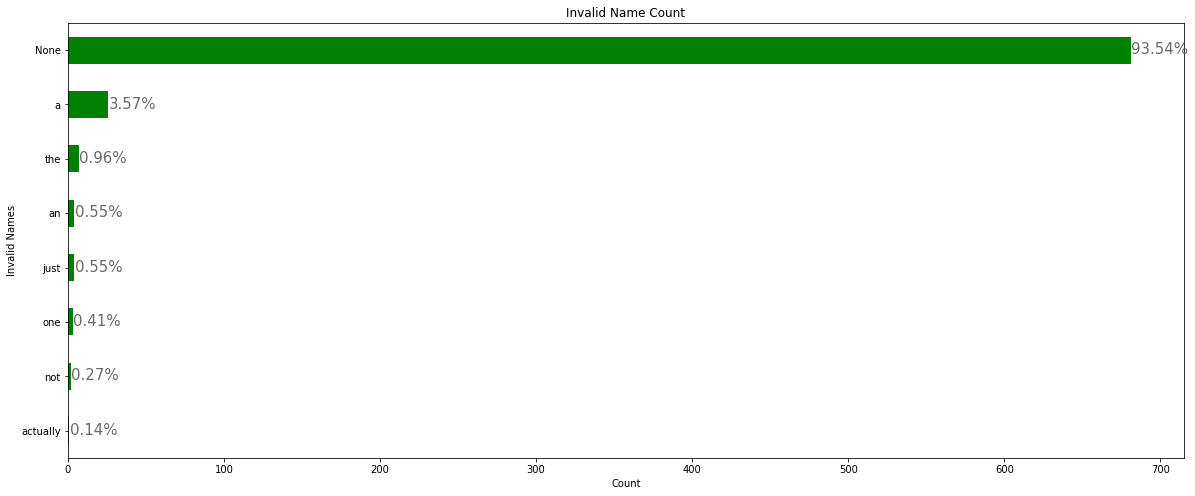

In [74]:
inn = invalid_names1.sort_values(ascending=True).plot.barh(figsize=(20,8), color = 'g');
inn.set_title('Invalid Name Count');
inn.set_xlabel('Count')
inn.set_ylabel('Invalid Names')

totals = []

for i in inn.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in inn.patches:
    # get_width pulls left or right; get_y pushes up or down
    inn.text(i.get_width()+.3, i.get_y()+.18, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

In [75]:
denoRateCount(tw_ar_mast_df)

{'Greater than 10': 0, 'Less than 10': 0}

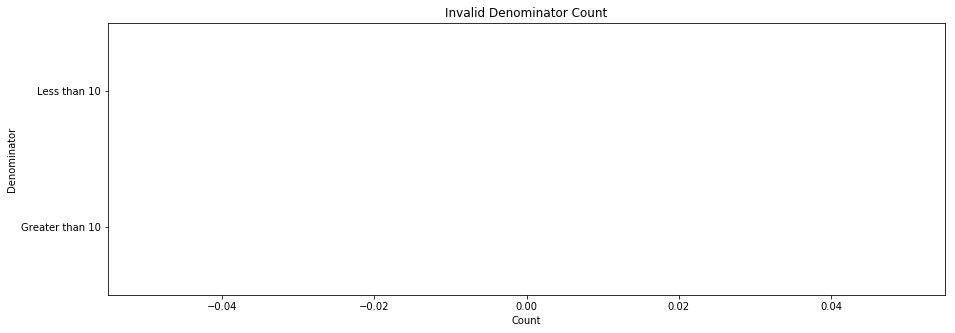

In [76]:
denorate = pd.Series(denocount)
grh = denorate.sort_values(ascending=True).plot.barh(figsize=(15,5));
grh.set_title('Invalid Denominator Count');
grh.set_xlabel('Count');
grh.set_ylabel('Denominator');

In [77]:
dogStageCount(tw_ar_mast_df)
dogstagecount.items()

dict_items([('doggo', 106), ('floofer', 10), ('pupper', 276), ('puppo', 38), ('None', 1976)])

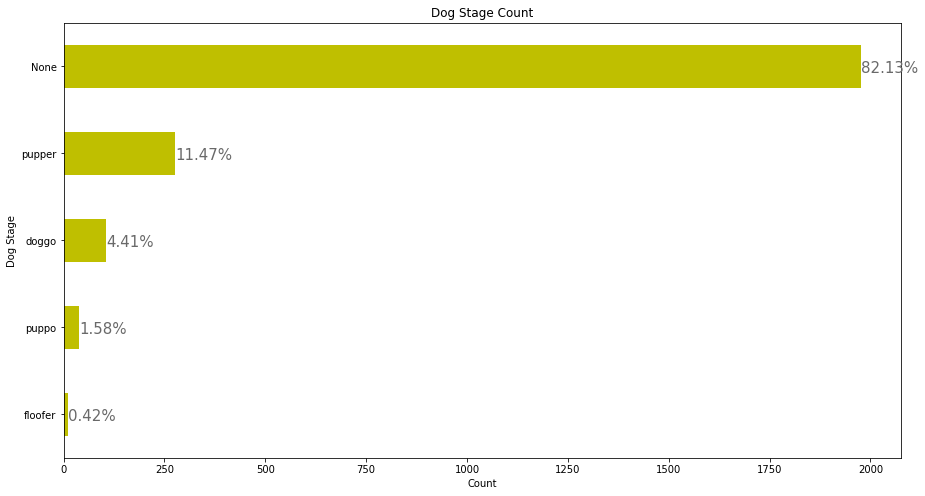

In [78]:
dogstage = pd.Series(dogstagecount)
ds = dogstage.sort_values(ascending=True).plot.barh(figsize=(15,8), color = 'y');
ds.set_title('Dog Stage Count');
ds.set_xlabel('Count');
ds.set_ylabel('Dog Stage');

totals = []

for i in ds.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ds.patches:
    # get_width pulls left or right; get_y pushes up or down
    ds.text(i.get_width()+.3, i.get_y()+.18, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,
color='dimgrey')

<font color='blue'>
<a id='10'></a>
    
#### Merge retweet_count and favorite_count columns from tweet_json dataset with twitter-archive-enhanced dataset

#### Define
In order to improve the tidiness of the dataset I've decided to merge the <B>retweet_count</B> and <B>favorite_count</B> columns from tweet_json dataset with twitter-archive-enhanced dataset
</font>

In [79]:
twjs_df2 = twjs_df.copy()

In [80]:
twjs_df2.columns

Index(['contributors', 'coordinates', 'created_at', 'display_text_range',
       'entities', 'extended_entities', 'favorite_count', 'favorited',
       'full_text', 'geo', 'id', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable',
       'quoted_status', 'quoted_status_id', 'quoted_status_id_str',
       'quoted_status_permalink', 'retweet_count', 'retweeted',
       'retweeted_status', 'source', 'truncated', 'user'],
      dtype='object')

In [81]:
twjs_df2.drop(columns=['contributors', 'coordinates', 'created_at', 'display_text_range', 'entities', 'extended_entities', 
                       'favorited', 'full_text', 'geo', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
                       'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status',
                       'lang', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable', 'quoted_status', 
                       'quoted_status_id', 'quoted_status_id_str', 'quoted_status_permalink', 'retweeted', 'retweeted_status',
                       'source', 'truncated', 'user'], inplace=True)

In [82]:
twjs_df2.columns

Index(['favorite_count', 'id', 'retweet_count'], dtype='object')

In [83]:
cols = ['id','favorite_count', 'retweet_count']

In [84]:
twjs_df2 = twjs_df2[cols]

In [85]:
twjs_df2.rename(columns={'id':'tweet_id'}, inplace=True)

In [86]:
twjs_df2.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,37024,7899
1,892177421306343426,31860,5870
2,891815181378084864,23996,3874
3,891689557279858688,40357,8065
4,891327558926688256,38561,8735


In [87]:
tw_ar_mast_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [88]:
tw_ar_mast_df2 = pd.merge(tw_ar_mast_df, twjs_df2, on='tweet_id', how='outer')

In [93]:
tw_ar_mast_df2.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,None,None,None,None,37024.0,7899.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,None,None,None,None,31860.0,5870.0


<font color='blue'>
<a id='10'></a>
    
#### Merge image-predictions dataset with twitter-archive-enhanced dataset

#### Define
I'm merging all columns from image-predictions dataset with twitter-archive-enhanced dataset
</font>

In [90]:
im_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [91]:
tw_ar_mast_df3 = pd.merge(tw_ar_mast_df2, im_df, on='tweet_id', how='outer')

In [92]:
tw_ar_mast_df3.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,None,None,None,None,37024.0,7899.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,None,None,None,None,31860.0,5870.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,None,None,None,None,23996.0,3874.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True


<a id='insight'></a>
<font color='blue'>
    
    
    
## Insights & Visualizations
<br>

<font color = 'blue'>

1. Top 5 Most talked about dog breed

As the first insight, I've analysed the <B>p1</B> ,<B>p1_conf</B> and <B>p1_dog</B> columns to determine the valid dog's name and derived the count in order to determine the breed of dog that most users have.
</font>

In [94]:
conf_dogs = tw_ar_mast_df3.loc[(tw_ar_mast_df3.p1_conf > 0.95) & (tw_ar_mast_df3.p1_dog == True)]

In [95]:
pop_dogs = conf_dogs['p1'].value_counts()

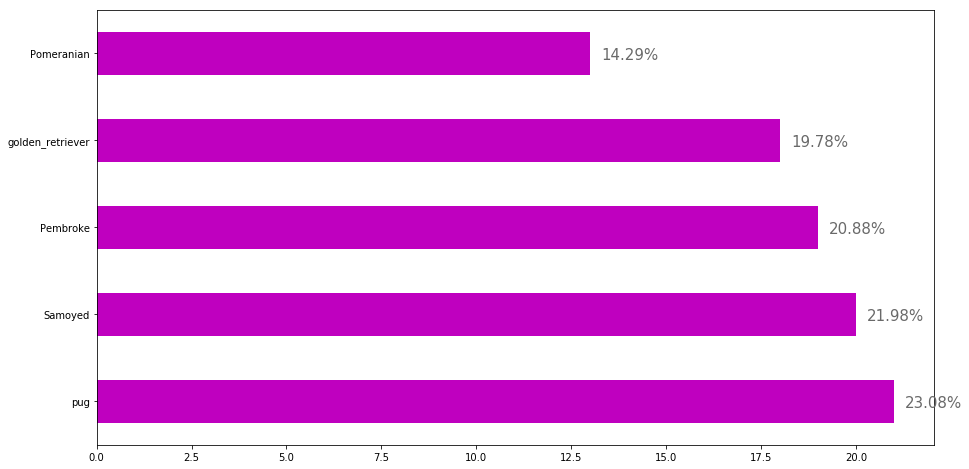

In [96]:
pd = pop_dogs[pop_dogs.values > 10].plot.barh(figsize=(15,8), color = 'm');

totals = []

for i in pd.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in pd.patches:
    # get_width pulls left or right; get_y pushes up or down
    pd.text(i.get_width()+.3, i.get_y()+.18, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=15, color='dimgrey')

<font color='blue'>

2. Word Cloud

A word cloud is “an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance.
Reference: [ProWritingAid](https://prowritingaid.com/art/425/What-the-Heck-is-a-Word-Cloud-and-Why-Would-I-Use-One.aspx)

Below is a word cloud created based on the text column to instantly see what words are used more frequently about dogs.
</font>

In [97]:
newline = []
for txt,j in zip(tw_ar_mast_df3.text, tw_ar_mast_df3[tw_ar_mast_df3.text.notnull()].text.str.find('http').values):
    newline.append(txt[:j])
    #print(txt[:j])

In [98]:
newline[:2]

["This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 ",
 "This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 "]

<font color='brown'>
#The following code was taken from https://www.geeksforgeeks.org/generating-word-cloud-python/
</font>

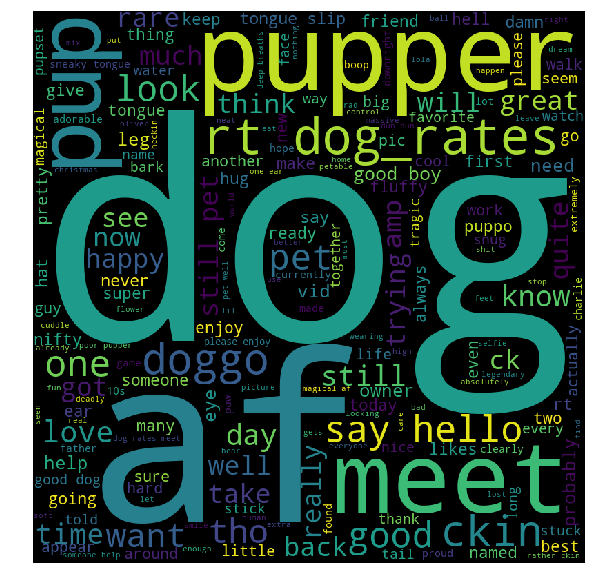

In [99]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

  
# Reads 'Youtube04-Eminem.csv' file  
#df = pd.read_csv(r"Youtube04-Eminem.csv", encoding ="latin-1") 
  
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the newline list 
for val in newline: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

<font color='blue'>

3. Dog Stage vs Favourite Count

The below analysis shows a comparison view of the favourite count and retweet count.
</font>

In [100]:
dsvsfc = {} #Dict for dog stage vs favourite count
dsvsrc = {} #Dict for dog stage vs retweet count
stage = ['doggo','pupper','floofer','puppo']

for s in stage:
    val = tw_ar_mast_df3.groupby(s)['favorite_count'].sum()[1]
    dsvsfc[s] = val
    val = tw_ar_mast_df3.groupby(s)['retweet_count'].sum()[1]
    dsvsrc[s] = val

sorted(dsvsfc.values())
#sorted(dsvsrc.values())

[21706.0, 98939.0, 175389.0, 214502.0]

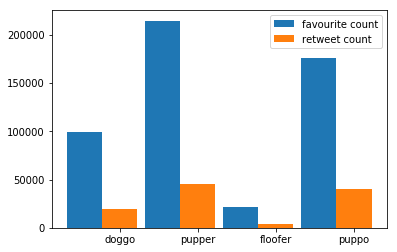

In [101]:
barWidth = 0.45

ax = plt.subplot(111)
ax.bar(np.arange(len(dsvsfc)),list(dsvsfc.values()),width=barWidth);
ax.bar([x + barWidth for x in np.arange(len(dsvsrc))],list(dsvsrc.values()),width=barWidth);
ax.legend(('favourite count','retweet count'))
plt.xticks([r + barWidth for r in range(len(dsvsfc))], ['doggo','pupper','floofer','puppo']);

<font color='blue'>

4. Weekly social media activity

This gives a view of the number of retweets that occur on a weekly basis
</font>

In [102]:
tw_ar_mast_df3['timestamp'] = tw_ar_mast_df3['timestamp'].astype('datetime64[ns]') 

In [103]:
tw_ar_mast_df3['year'], tw_ar_mast_df3['month'] = tw_ar_mast_df3['timestamp'].dt.year, tw_ar_mast_df3['timestamp'].dt.month

In [107]:
retweet_week_cnt = tw_ar_mast_df3.groupby(['year','month', pd.Grouper(key='timestamp', freq='W-MON')])['retweet_count'].sum().reset_index().sort_values('timestamp')

In [108]:
retweet_week_cnt[retweet_week_cnt.retweet_count > 0]

,year,month,timestamp,retweet_count
97,2017.0,6.0,2017-06-05,3292.0
98,2017.0,6.0,2017-06-12,59012.0
99,2017.0,6.0,2017-06-19,51020.0
100,2017.0,6.0,2017-06-26,114967.0
101,2017.0,6.0,2017-07-03,22689.0
102,2017.0,7.0,2017-07-03,33023.0
103,2017.0,7.0,2017-07-10,78610.0
104,2017.0,7.0,2017-07-17,87132.0
105,2017.0,7.0,2017-07-24,64446.0
106,2017.0,7.0,2017-07-31,79097.0


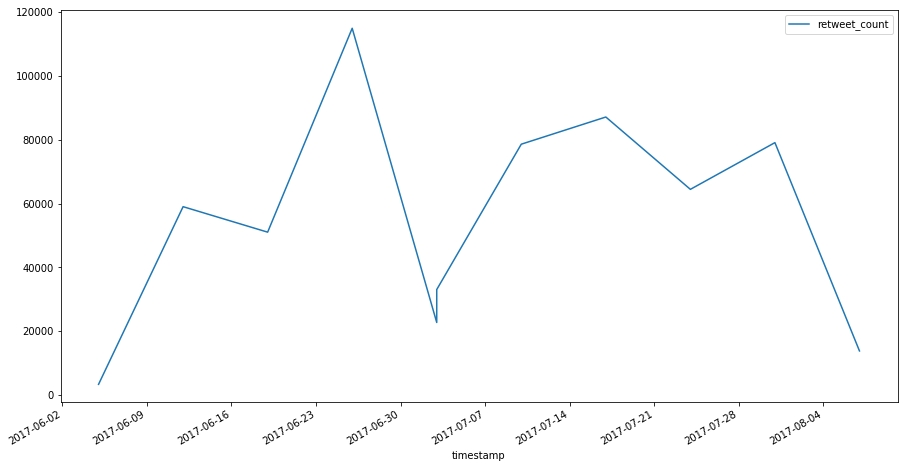

In [109]:
retweet_week_cnt[retweet_week_cnt.retweet_count > 0].plot(x='timestamp', y='retweet_count', figsize=(15,8));

In [111]:
tw_ar_mast_df3.loc[(tw_ar_mast_df3.year == 2017) & (tw_ar_mast_df3.month == 6) & (tw_ar_mast_df3.retweet_count > 40000)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,favorite_count,retweet_count,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,year,month
64,879415818425184262,NaN,NaN,2017-06-26 19:07:24,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Duddles. He did an attempt. 13/10 someone help him (vid by Georgia Felici) https://t.co/UDT7ZkcTgY,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879415818425184262/video/1,13.0,10.0,Duddles,None,None,None,None,101468.0,41599.0,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg,1.0,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True,2017.0,6.0


<font color='blue'>
The above graph shows a sudden spike on the week starting 2017-06-23. I was able pinpoint the tweet that was retweeted more than 41000 times.
    </font

<font color='blue'>

#### Create master CSV
</font>

In [112]:
export_csv = tw_ar_mast_df3.to_csv('twitter_archive_master.csv')